In [65]:
import os
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import f_oneway
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime
from dateutil import tz

In [33]:
with open('../config.json', 'r') as config_file:
    config = json.load(config_file)

df = pd.read_csv(os.path.join(config['data_path'], 'full_kpis.csv'), index_col=0)
print(df.shape)
df.head()

(12741835, 10)


,cell,bts,antenna,carrier,minRSSI,pageSessions,ULvol,sessionSetupDur,sessionDur,blocks
timestamp,,,,,,,,,,
2023-09-01 02:30:00,154_0_1,154,0,1,-102.50,78.0,0.829355,17.457447,18.521277,0
2023-09-01 02:30:00,154_1_1,154,1,1,-103.84,159.0,1.450913,27.500000,29.200000,0
2023-09-01 02:30:00,154_2_1,154,2,1,-104.92,60.0,0.746502,4.558011,4.795580,0
2023-09-01 02:30:00,162_0_0,162,0,0,-104.19,43.0,0.436677,84.500000,88.785714,0
2023-09-01 02:30:00,162_0_1,162,0,1,-103.93,48.0,0.519392,90.785714,96.428571,0


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12741835 entries, 2023-09-01 02:30:00 to 2024-10-02 22:00:00
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   cell             object 
 1   bts              int64  
 2   antenna          int64  
 3   carrier          int64  
 4   minRSSI          float64
 5   pageSessions     float64
 6   ULvol            float64
 7   sessionSetupDur  float64
 8   sessionDur       float64
 9   blocks           int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 1.0+ GB


In [35]:
kpis = [col for col in df.columns if col not in ['timestamp', 'cell', 'bts', 'antenna', 'carrier']]

In [36]:
df[kpis].describe().apply(lambda x: x.apply(lambda y: f"{y:.2f}"))

,minRSSI,pageSessions,ULvol,sessionSetupDur,sessionDur,blocks
count,12741835.00,12741835.00,12741835.00,12741835.00,12741835.00,12741835.00
mean,-106.12,107.18,0.86,48.18,51.15,0.03
std,3.17,175.70,1.46,103.48,109.11,4.35
min,-136.17,0.00,0.00,0.00,0.00,0.00
25%,-108.30,8.00,0.05,7.66,8.28,0.00
50%,-106.63,37.00,0.21,15.33,16.50,0.00
75%,-104.60,132.00,1.03,49.15,52.40,0.00
max,-45.65,4237.00,45.29,6540.00,6925.00,5062.00


In [37]:
# Show how many bts have two carriers and how many have one carrier
df.groupby('bts').agg({'carrier': 'nunique'}).carrier.value_counts()

1    109
2     62
Name: carrier, dtype: int64

In [38]:
# Check the amount of BTS+antenna combinations
df.groupby(['bts', 'antenna']).size().count()

484

In [39]:
# Check the amount of unique cells
df.cell.nunique()

668

# Visualize

In [43]:
df.reset_index(inplace=True)

In [44]:
def plot_bts_kpi(df, bts, kpi='minRSSI'):
    # Filter the dataframe for the selected BTS
    df_bts = df[df['bts'] == bts].copy()
    
    # Convert timestamp to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df_bts['timestamp']):
        df_bts['timestamp'] = pd.to_datetime(df_bts['timestamp'])
    
    # Set up the plot
    #plt.figure(figsize=(16, 8))
    plt.figure(figsize=(12, 6))
    
    # Color map for antennas
    colors = ['blue', 'green', 'red']
    
    # Plot for each antenna and carrier
    for antenna in df_bts['antenna'].unique():
        for carrier in df_bts['carrier'].unique():
            data = df_bts[(df_bts['antenna'] == antenna) & (df_bts['carrier'] == carrier)]
            
            if not data.empty:
                color = colors[antenna]
                linestyle = '--' if carrier == 0 else '-'
                
                plt.plot(data['timestamp'], data[kpi], 
                         linestyle=linestyle, color=color, 
                         label=f'Antenna {antenna}, Carrier {carrier}')
    
    # Customize the plot
    #plt.title(f'{kpi} for BTS {bts}')
    plt.xlabel('Date')
    plt.ylabel(kpi)
    
    # Set x-axis ticks to show date once in 2 weeks
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=4))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    # Rotate and align the tick labels so they look better
    plt.gcf().autofmt_xdate()
    
    # Add legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Make a less dense grid
    plt.grid(True, which='major', linestyle='--', color='gray', alpha=0.5)
    
    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    
    # Show the plot
    plt.show()

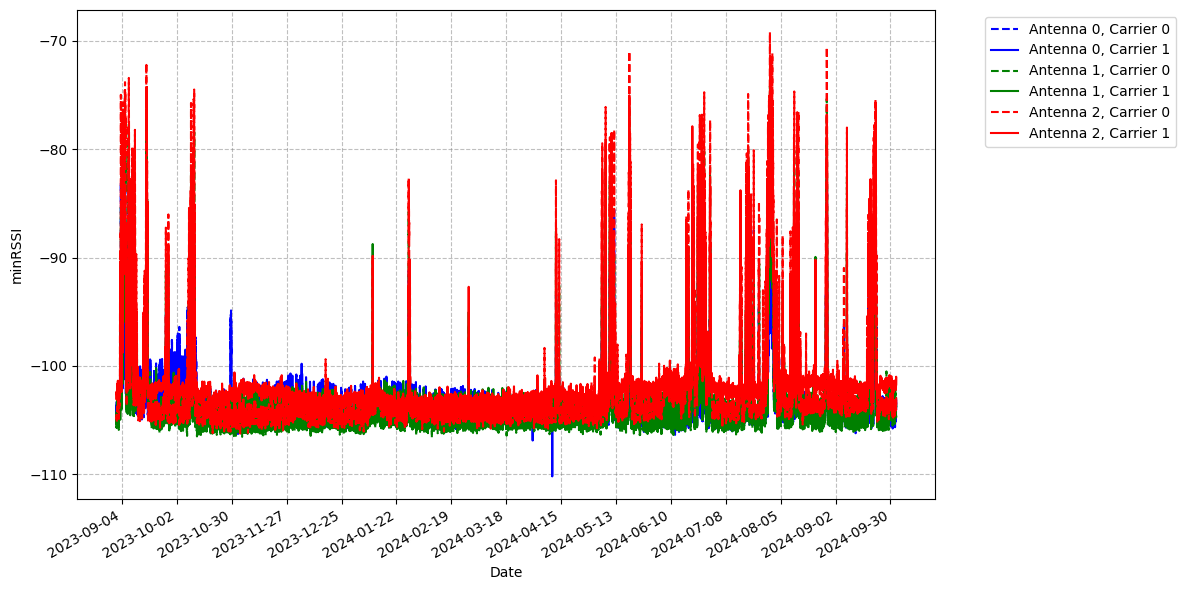

In [45]:
plot_bts_kpi(df, 180, 'minRSSI')

## Time series analysis

### Seasonality

https://medium.com/@datasciencewizards/preprocessing-and-data-exploration-for-time-series-decomposing-time-series-a44e074c5847

In [46]:
# convert timestamp to datetime and set as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

In [47]:
# Resample to daily frequency and calculate mean KPIs
daily_data = df.resample('D').agg({kpi: 'mean' for kpi in kpis})
daily_data.head()

,minRSSI,pageSessions,ULvol,sessionSetupDur,sessionDur,blocks
timestamp,,,,,,
2023-09-01,-106.204557,150.975833,0.807048,61.210007,66.148876,0.012538
2023-09-02,-106.187322,134.062905,0.726642,58.319029,62.705594,0.003431
2023-09-03,-104.051846,142.902695,0.747008,62.755014,67.811236,0.000811
2023-09-04,-103.114978,141.136945,0.731620,58.376261,63.083555,0.002214
2023-09-05,-102.196005,135.305878,0.732276,53.852956,58.004547,0.001310


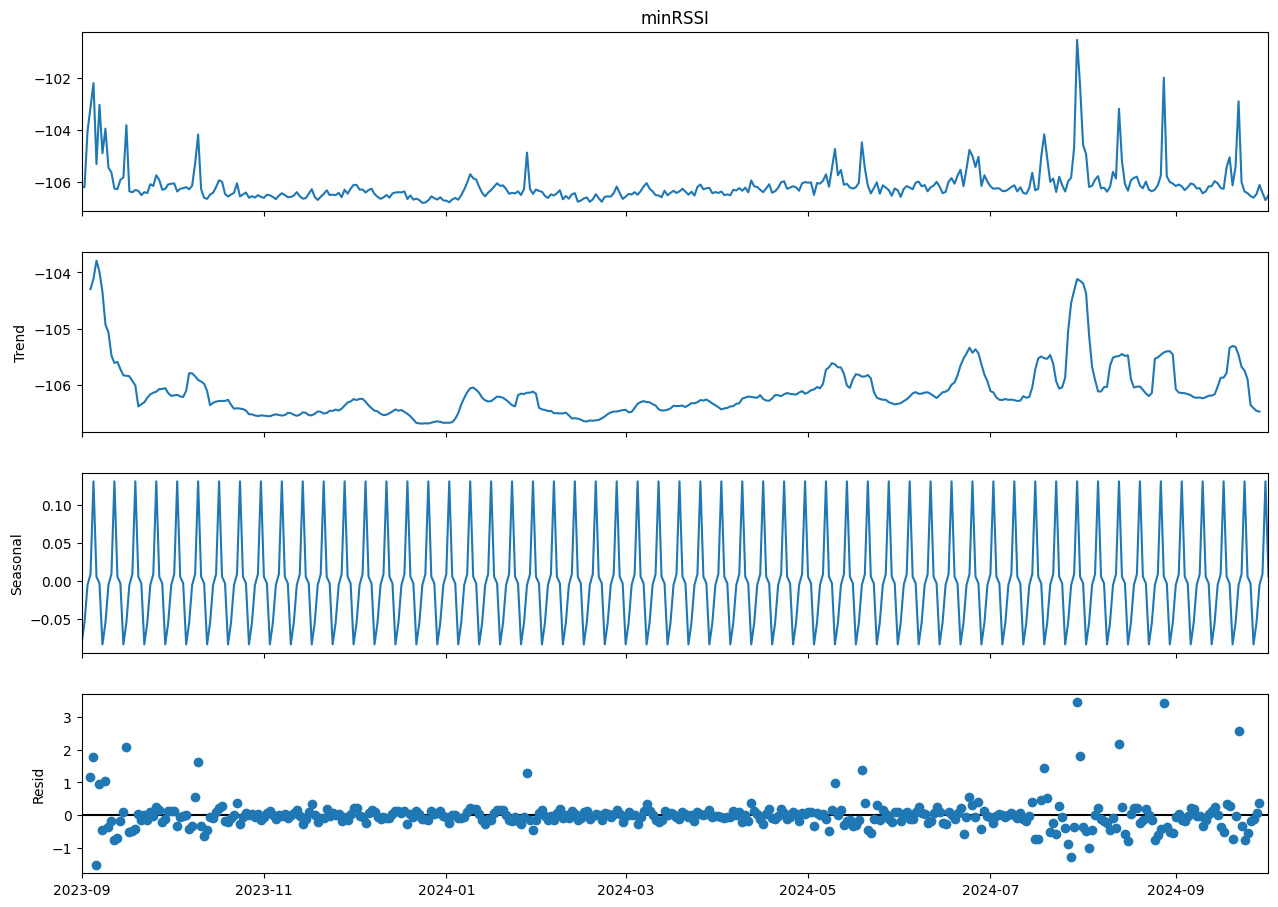

In [48]:
# Perform decomposition
decomposition1 = seasonal_decompose(daily_data['minRSSI'], model='additive', period=7)

# Plot the decomposition
fig = decomposition1.plot()
fig.set_size_inches(14, 10)
plt.show()

### Temporal patterns

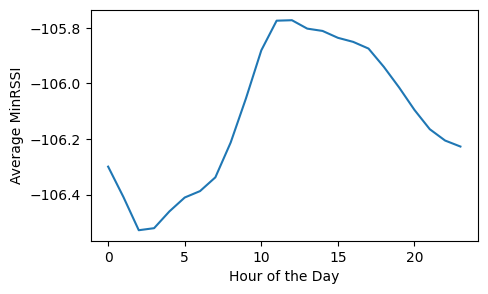

Daily Pattern ANOVA: F-statistic = 0.5552038107293316, p-value = 0.7659029516884426


In [49]:
# Daily pattern
df['hour'] = df.index.hour
hourly_avg = df.groupby('hour')['minRSSI'].mean()
hourly_avg.plot(kind='line', figsize=(5, 3))
plt.xlabel('Hour of the Day')
plt.ylabel('Average MinRSSI')
plt.show()

# ANOVA test for daily pattern
daily_anova = f_oneway(*[daily_data[daily_data.index.dayofweek == i]['minRSSI'] for i in range(7)])
print(f"Daily Pattern ANOVA: F-statistic = {daily_anova.statistic}, p-value = {daily_anova.pvalue}")

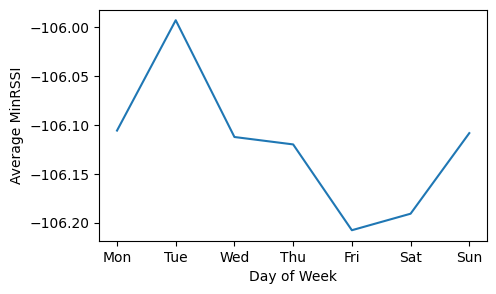

Weekly Pattern ANOVA: F-statistic = 4.73008582137539, p-value = 9.504457102972945e-19


In [50]:
# Weekly pattern
df['dayofweek'] = df.index.dayofweek
weekly_avg = df.groupby('dayofweek')['minRSSI'].mean()
weekly_avg.plot(kind='line', figsize=(5, 3))
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xticks(range(7), days)
plt.xlabel('Day of Week')
plt.ylabel('Average MinRSSI')
plt.show()

# ANOVA test for weekly pattern using isocalendar().week
weekly_anova = f_oneway(*[daily_data[daily_data.index.isocalendar().week == i]['minRSSI'] for i in range(1, daily_data.index.isocalendar().week.max() + 1)])
print(f"Weekly Pattern ANOVA: F-statistic = {weekly_anova.statistic}, p-value = {weekly_anova.pvalue}")

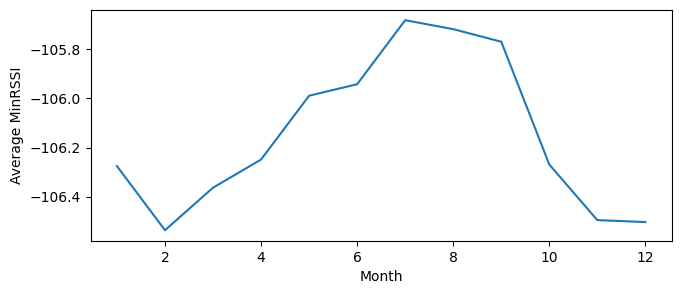

Monthly Pattern ANOVA: F-statistic = 10971.321317773176, p-value = 0.0


In [51]:
# Monthly pattern
df['month'] = df.index.month
monthly_avg = df.groupby('month')['minRSSI'].mean()
monthly_avg.plot(kind='line', figsize=(7.5, 3))
plt.xlabel('Month')
plt.ylabel('Average MinRSSI')
plt.show()

# Perform ANOVA test on monthly average minRSSI
monthly_anova = f_oneway(*[df[df['month'] == i]['minRSSI'] for i in range(1, 13)])
print(f"Monthly Pattern ANOVA: F-statistic = {monthly_anova.statistic}, p-value = {monthly_anova.pvalue}")

### Monthly variance

In [52]:
df.reset_index(inplace=True)

In [53]:
# Extract year and month from the timestamp
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month

# Group by year and month and calculate the variance of minRSSI
monthly_var_with_year = df.groupby(['year', 'month'])['minRSSI'].var()

# Display the result
monthly_var_with_year

year  month
2023  9        14.539276
      10        9.886274
      11        8.362900
      12        8.181354
2024  1         8.951523
      2         8.033851
      3         8.112961
      4         8.422546
      5         9.814698
      6         9.894337
      7        13.674824
      8        11.815125
      9         9.680375
      10        6.410766
Name: minRSSI, dtype: float64

## Correlation and distribution

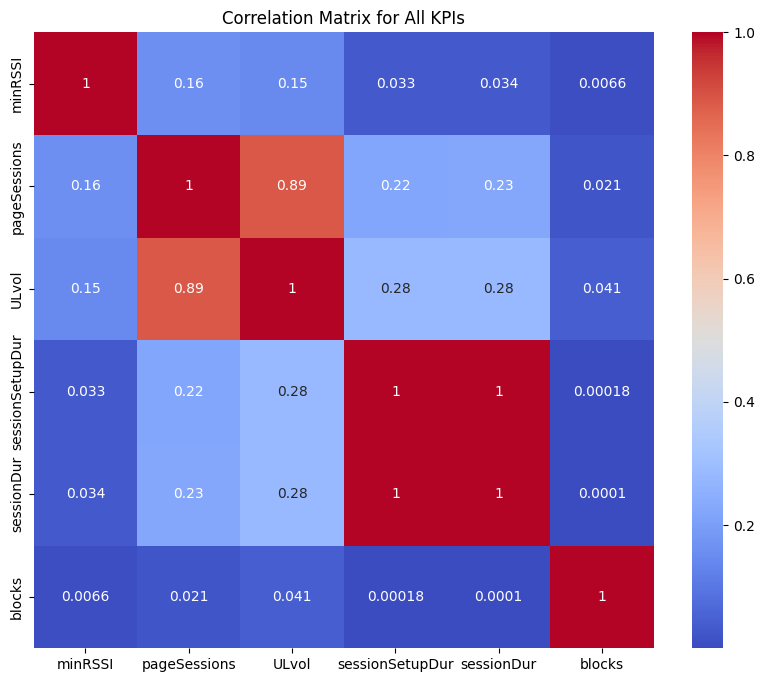

In [54]:
# Calculate the correlation matrix for all KPIs
correlation_matrix = df[kpis].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for All KPIs')
plt.show()

**sessionSetupDur** and **sessionDur** are too similar, so drop one of them. **blocks** is not correlated with any other KPIs, drop it too.

In [55]:
kpis = ['minRSSI', 'pageSessions', 'ULvol', 'sessionDur']

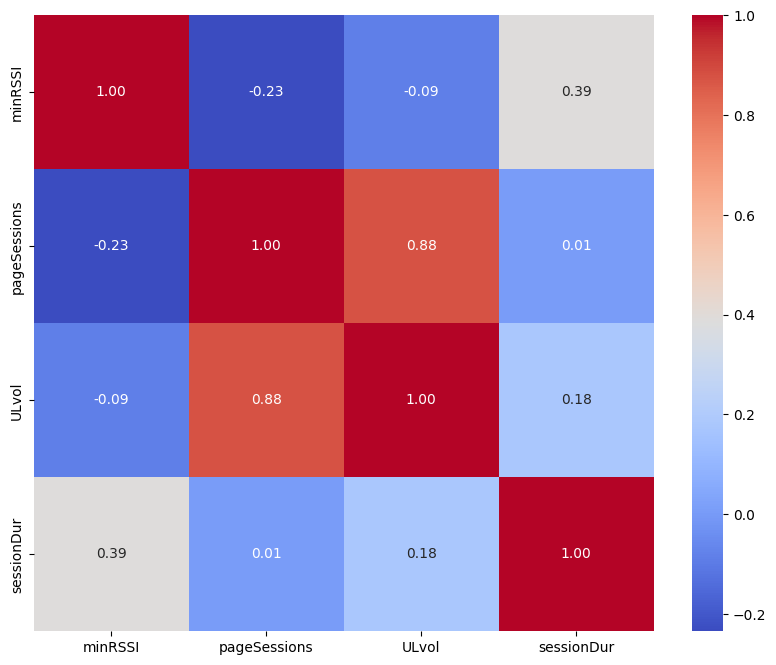

In [62]:
# Filter the dataframe for the selected BTS
sel_bts = 190
df_sel_bts = df[df['bts'] == sel_bts]

# Calculate the correlation matrix for all KPIs for the selected BTS
correlation_matrix_sel_bts = df_sel_bts[kpis].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_sel_bts, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [58]:
df.set_index('timestamp', inplace=True)

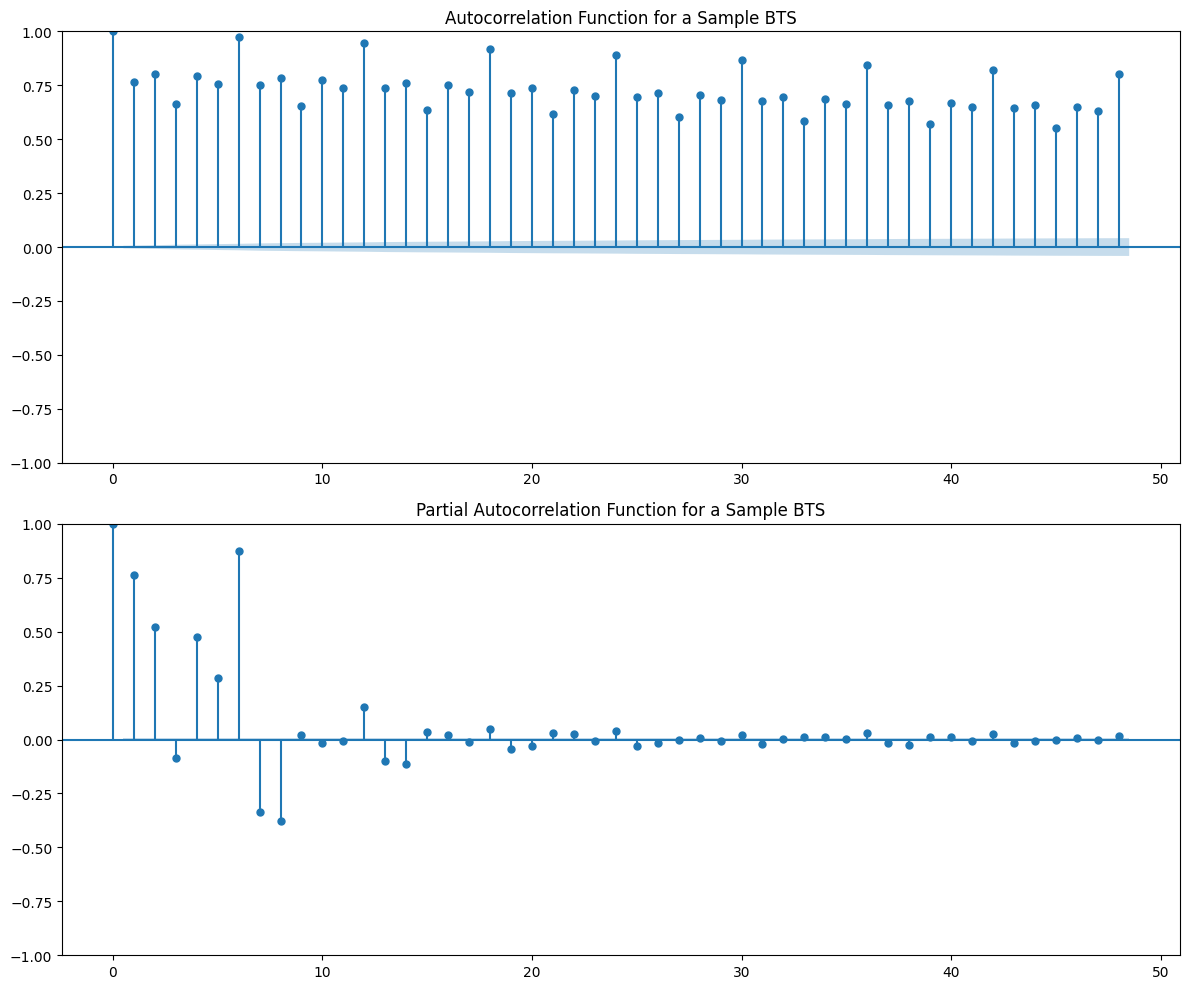

In [63]:
def plot_acf_pacf_for_bts(df, bts, lags=48):
    # Filter the dataframe for the selected BTS
    df_bts = df[df['bts'] == bts].copy()
    
    # Plot ACF and PACF
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    plot_acf(df_bts['minRSSI'], ax=ax1, lags=lags)
    ax1.set_title(f'Autocorrelation Function for a Sample BTS')
    plot_pacf(df_bts['minRSSI'], ax=ax2, lags=lags)
    ax2.set_title(f'Partial Autocorrelation Function for a Sample BTS')
    plt.tight_layout()
    plt.show()

# Example usage
plot_acf_pacf_for_bts(df, 180)

In [ ]:
# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df['minRSSI'], ax=ax1, lags=48)
ax1.set_title(f'Autocorrelation Function for minRSSI over all Cells')
plot_pacf(df['minRSSI'], ax=ax2, lags=48)
ax2.set_title(f'Partial Autocorrelation Function for minRSSI over all Cells')
plt.tight_layout()
plt.show()

**ACF**: The ACF plot shows the correlation of the time series with its own lagged values. The slow decay of correlations after lag 1 indicates that past values still have some influence over future values, suggesting persistence in the time series. Lag 0 always has an autocorr of 1 since it's the correlation of the series with itself.

**PACF**: PACF measures the correlation between the time series and its lagged values after removing the effect of intervening lags. The PACF plot has a significant spike at lag 1 followed by rapidly diminishing values. This suggests that the series is influenced by just the first lag. The drop-off after the first spike indicates that most of the autocorrelation in the time series can be explained by just the previous one value (lag 1).

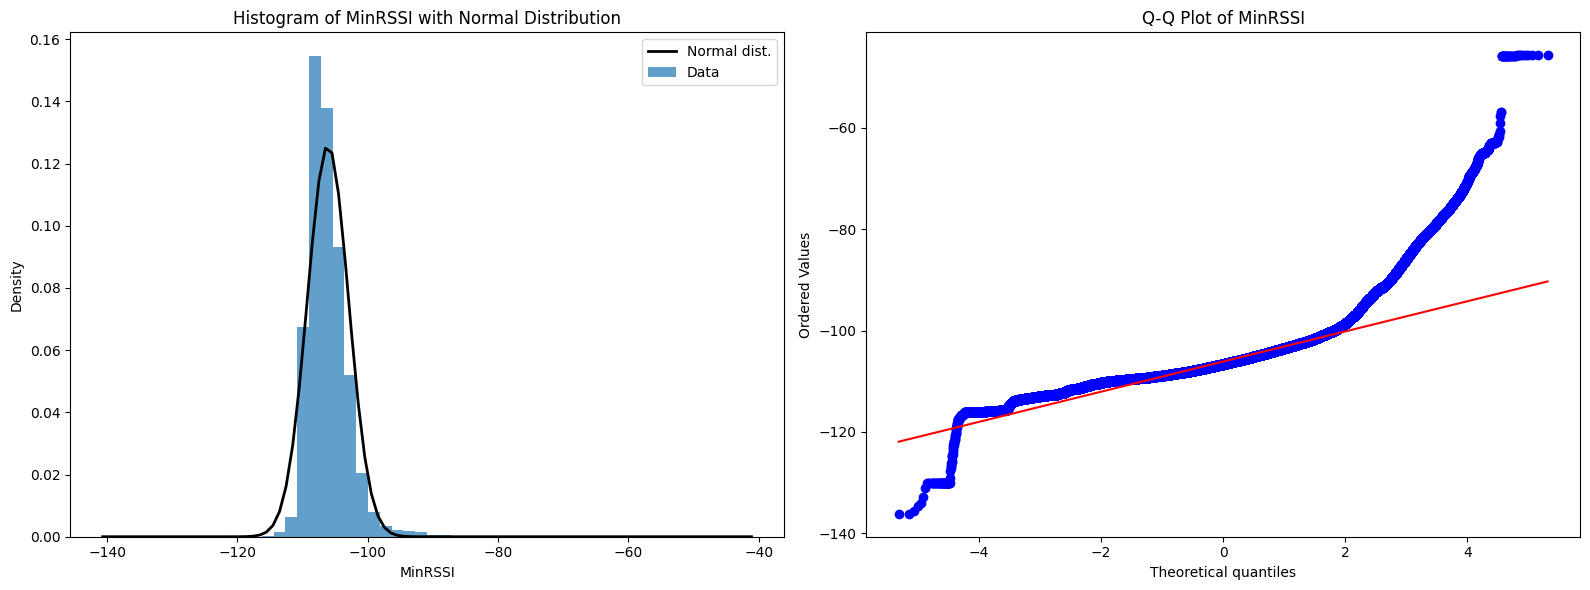

In [64]:
plt.figure(figsize=(16, 6))

# Histogram
plt.subplot(121)
n, bins, patches = plt.hist(df['minRSSI'], bins=50, density=True, alpha=0.7)
plt.title('Histogram of MinRSSI with Normal Distribution')
plt.xlabel('MinRSSI')
plt.ylabel('Density')
mu, std = df['minRSSI'].mean(), df['minRSSI'].std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.legend(['Normal dist.', 'Data'])

# Q-Q Plot
plt.subplot(122)
stats.probplot(df['minRSSI'], dist="norm", plot=plt)
plt.title('Q-Q Plot of MinRSSI')
plt.tight_layout()
plt.show()

**Q-Q Plot**: The middle section of the data (from approximately -4 to 2 on the theoretical quantiles) follows the reference line closely. This suggests that the central part of the distribution is reasonably close to normal. The steep increase from the x-axis value of 2 onwards indicates that the data has more extreme high values than expected in a normal distribution. Compare with the histogram on the left.